In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
from PIL import Image
import sys
import os
import pandas as pd
sys.path.append(r'../Data/')
from dataloader import Data

In [2]:
def plotLosses(model_save_path):
    
    # Find csv
    files = os.listdir(model_save_path)
    csv_file = [file for file in files if ".csv" in file][0] 
    loss = pd.read_csv(os.path.join(model_save_path, csv_file))
    
    plt.title("Training Loss Curve")
    plt.plot(loss, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()
    

In [12]:
def longestSubstringFinder(string1, string2):
    answer = ""
    len1, len2 = len(string1), len(string2)
    for i in range(len1):
        match = ""
        for j in range(len2):
            if (i + j < len1 and string1[i + j] == string2[j]):
                match += string2[j]
            else:
                if (len(match) > len(answer)): answer = match
                match = ""
    return answer

def getUniqueBtwStrings(strings):
    
    common_factor = longestSubstringFinder(strings[0], strings[1])
    unique = []
    for string in strings:
        r = string.replace(common_factor, "").replace("_epoch", "")
        unique.append(r)
    return unique

def findBs(string):
    end_idx = string.find("_bs")
    return string[:end_idx]

def getAccuracy(model, data_loader, use_cuda):

    cor = 0
    total = 0
    n = 0
    for imgs, labels in data_loader:
        imgs = torch.from_numpy(imgs.detach().numpy())
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
            imgs = imgs.cuda()
            labels = labels.cuda()
        #############################################
        output = model(imgs)
        pred = output.max(1, keepdim=True)[1]
        cor = cor + pred.eq(labels.view_as(pred)).sum().item()
        total = total + imgs.shape[0]
        n = n+1
    return cor / total

def plotAccuracy(model_class, model_save_path, val_dataset, train_dataset = None, use_cuda = False):
    
    model_dicts = [file for file in os.listdir(model_save_path) if ".csv" not in file]
    if train_dataset:
        t_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=findBs(model_dicts[0]))
    v_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32)
    epochs, t_accs, v_accs = getUniqueBtwStrings(model_dicts), [], []
    i = 0
    
    # for each model dict, create model
    for model_params in model_dicts:
        print(i)
        # load model
        model = model_class()
        checkpoint = torch.load(os.path.join(model_save_path, model_params))
        model.load_state_dict(checkpoint)
        # get acc for model and append
        if train_dataset:
            t_accs.append(getAccuracy(model, t_data_loader, use_cuda))
        v_accs.append(getAccuracy(model, v_data_loader, use_cuda))
        i+=1
    
    # Plot    
    plt.title("Training vs. Validation Accuracy Curves")
    if train_dataset:
        plt.plot(epochs, t_accs, label="Train")
    plt.plot(epochs, v_accs, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show() 

# Example

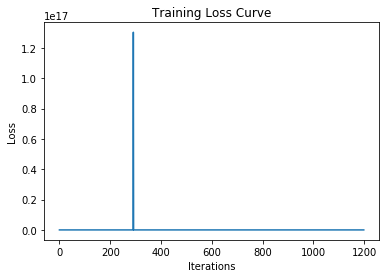

In [5]:
plotLosses("Model_Overfit_detector_Alex")

In [11]:
import torch.nn as nn
import torchvision.models

val_folders = [
    "../Data/Processed/val/epidural",
    "../Data/Processed/val/intraparenchymal",
    "../Data/Processed/val/subarachnoid",
    "../Data/Processed/val/intraventricular",
    "../Data/Processed/val/subdural",
    "../Data/Processed/val/nohem",
]

val_data = Data(val_folders, {
    "epidural":"any", 
    "intraparenchymal":"any", 
    "subarachnoid":"any", 
    "intraventricular":"any", 
    "subdural":"any", 
}, 10)

# from Full_detector_training import HemorrhageDetector

alexnet_model = torchvision.models.alexnet(pretrained=True)
alexnet_model.features[0] = nn.Conv2d(1, 64, kernel_size= 7, stride= 2, padding= 3)

class HemorrhageDetector(nn.Module):
    def __init__(self):
        super(HemorrhageDetector, self).__init__()
        self.name = "Detector"

        for param in alexnet_model.parameters():
              param.requires_grad = False

        self.fc1 = nn.Linear(256*31*31, 100)
        self.fc2 = nn.Linear(100, 2)

    def forward(self, x):
        x = alexnet_model.features(x)
#         print(x.shape)
        x = x.view(-1, 256*31*31)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

Unpacking epidural
Unpacking intraparenchymal
Unpacking subarachnoid
Unpacking intraventricular
Unpacking subdural
Unpacking nohem


In [ ]:
plotAccuracy(HemorrhageDetector, "Model_Overfit_detector_Alex", val_data)

0
1
2
3
